http://htmlpreview.github.io/?https://github.com/immunogenomics/harmony/blob/master/docs/SeuratV3.html

In [2]:
library(Seurat)
library(harmony)
library(cowplot)
library(dplyr)

library(ggplot2)
set.seed(1)

library(ggsci)
packageVersion("Seurat")

[1] ‘4.3.0.1’

### Clustering and UMAP

In [3]:
obj = readRDS('./merged_counts_70824x39123.20240227.RDS')

In [4]:
ast = CreateSeuratObject(counts = obj@assays[['RNA']]@counts, 
                         meta.data = obj@meta.data[c('SampleName','Unified_region','Donor.ID','Path..Group.')],
                         project = "ast", min.cells = 50)
ast

An object of class Seurat 
25802 features across 70824 samples within 1 assay 
Active assay: RNA (25802 features, 0 variable features)

In [5]:
ast[["percent.mt"]] <- PercentageFeatureSet(ast, pattern = "^MT-")

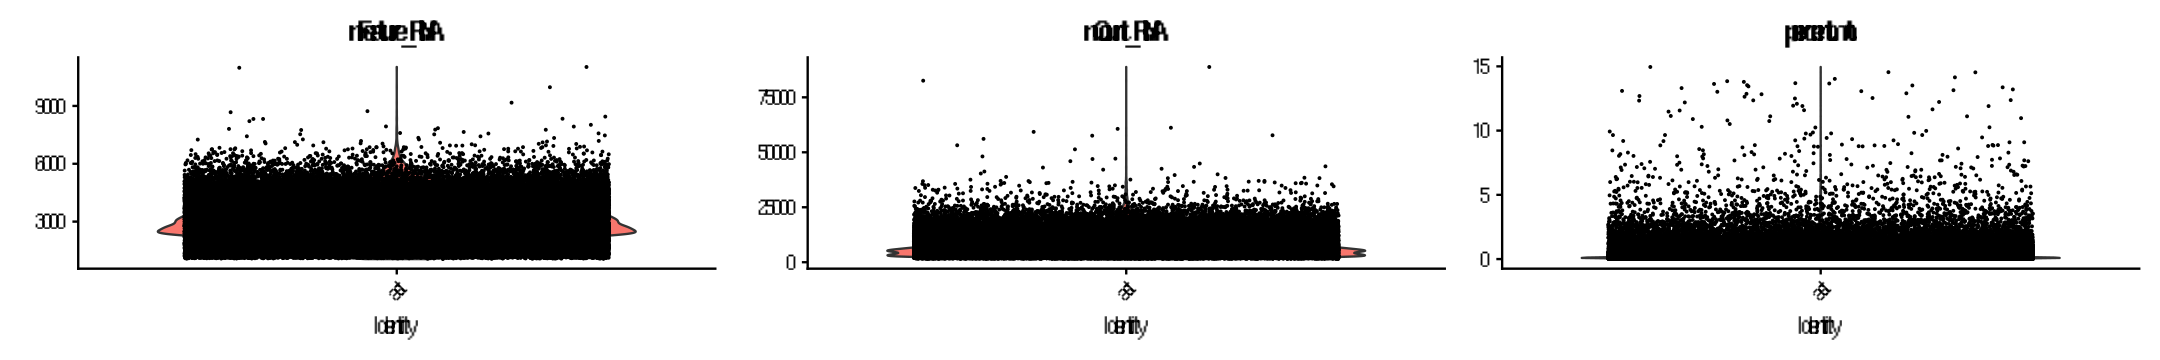

In [6]:
options(repr.plot.width = 18, repr.plot.height = 3)
VlnPlot(ast, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size=0.05)

In [7]:
dim(ast)
ast@meta.data$samp_n <- ast@meta.data %>% group_by(SampleName) %>% mutate(samp_n = n()) %>% pull(samp_n)
ast <- subset(ast, subset = percent.mt <= 10)
ast <- subset(ast, subset = samp_n > 100)
ast

[1] 25802 70824

An object of class Seurat 
25802 features across 70674 samples within 1 assay 
Active assay: RNA (25802 features, 0 variable features)

In [8]:
ast = ast %>%
    Seurat::NormalizeData(verbose = FALSE) %>%
    FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>% 
    ScaleData(verbose = FALSE) %>% 
    RunPCA(pc.genes = ast@var.genes, npcs = 20, verbose = FALSE)

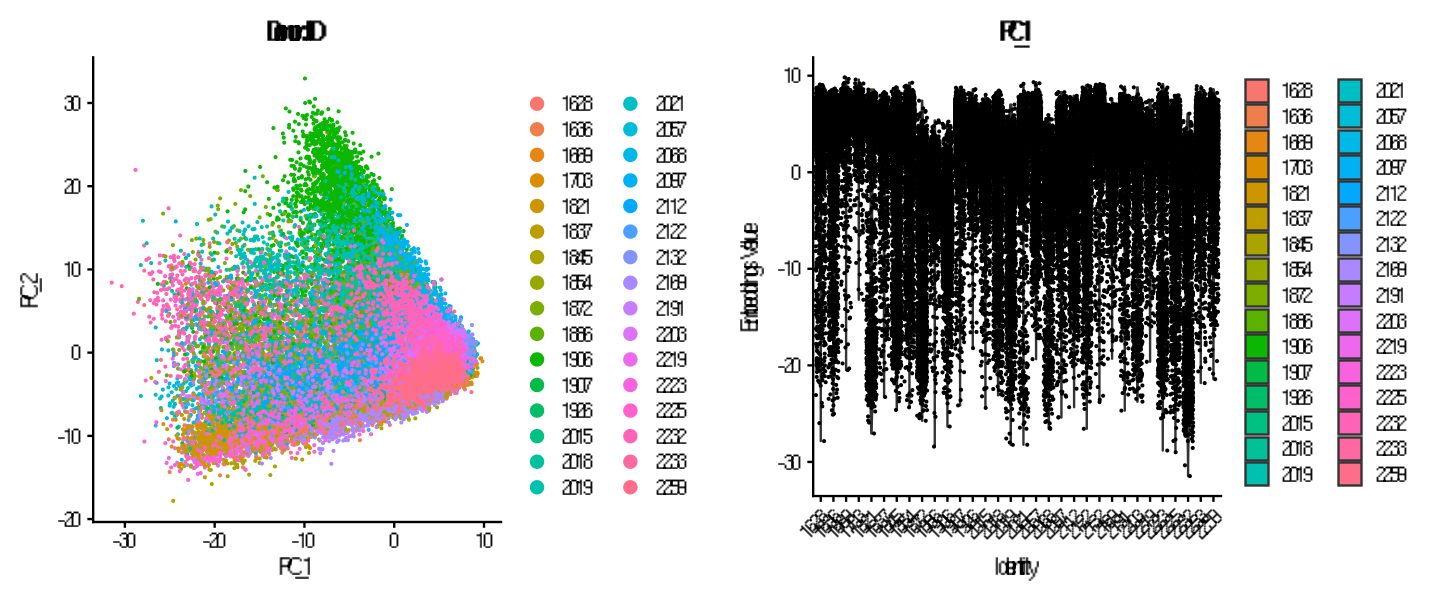

In [9]:
options(repr.plot.height = 5, repr.plot.width = 12)
p1 <- DimPlot(object = ast, reduction = "pca", pt.size = .1, group.by = "Donor.ID")
p2 <- VlnPlot(object = ast, features = "PC_1", group.by = "Donor.ID", pt.size = .1)
plot_grid(p1,p2)

##### Harmony

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


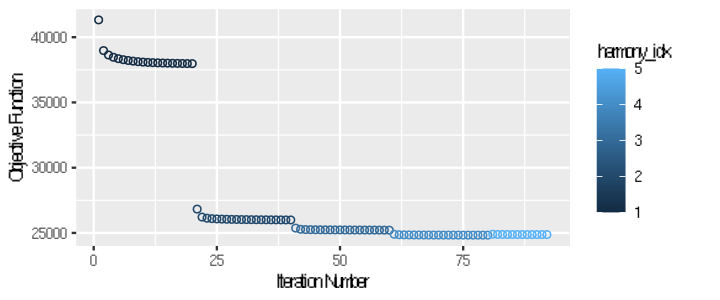

In [10]:
options(repr.plot.height = 2.5, repr.plot.width = 6)
ast <- ast %>% 
    RunHarmony("SampleName", plot_convergence = TRUE, lambda = 1)

In [11]:
harmony_embeddings <- Embeddings(ast, 'harmony')
harmony_embeddings[1:5, 1:5]

harmony_1 harmony_2  harmony_3  harmony_4 
AAACCCACAGGTGTTT-1_6289-MW-0031  3.940554 -0.4115052 -0.9662511  1.7091618
AAACGAAGTTAATGAG-1_6289-MW-0031  3.896287  1.1074591  0.4479092  0.4697702
AAAGGATAGTGCACAG-1_6289-MW-0031  2.563350  0.4627662 -7.3195732 -7.7213725
AACAGGGGTTAGCTAC-1_6289-MW-0031 -5.948378  6.1195867 -2.6383694  1.9942037
AACCACATCCTTACCG-1_6289-MW-0031  1.722367 -1.2083163 -0.9235201  2.5914294
                                harmony_5 
AAACCCACAGGTGTTT-1_6289-MW-0031  1.8886917
AAACGAAGTTAATGAG-1_6289-MW-0031  1.1728343
AAAGGATAGTGCACAG-1_6289-MW-0031  2.5591412
AACAGGGGTTAGCTAC-1_6289-MW-0031 -4.2657877
AACCACATCCTTACCG-1_6289-MW-0031  0.5550396

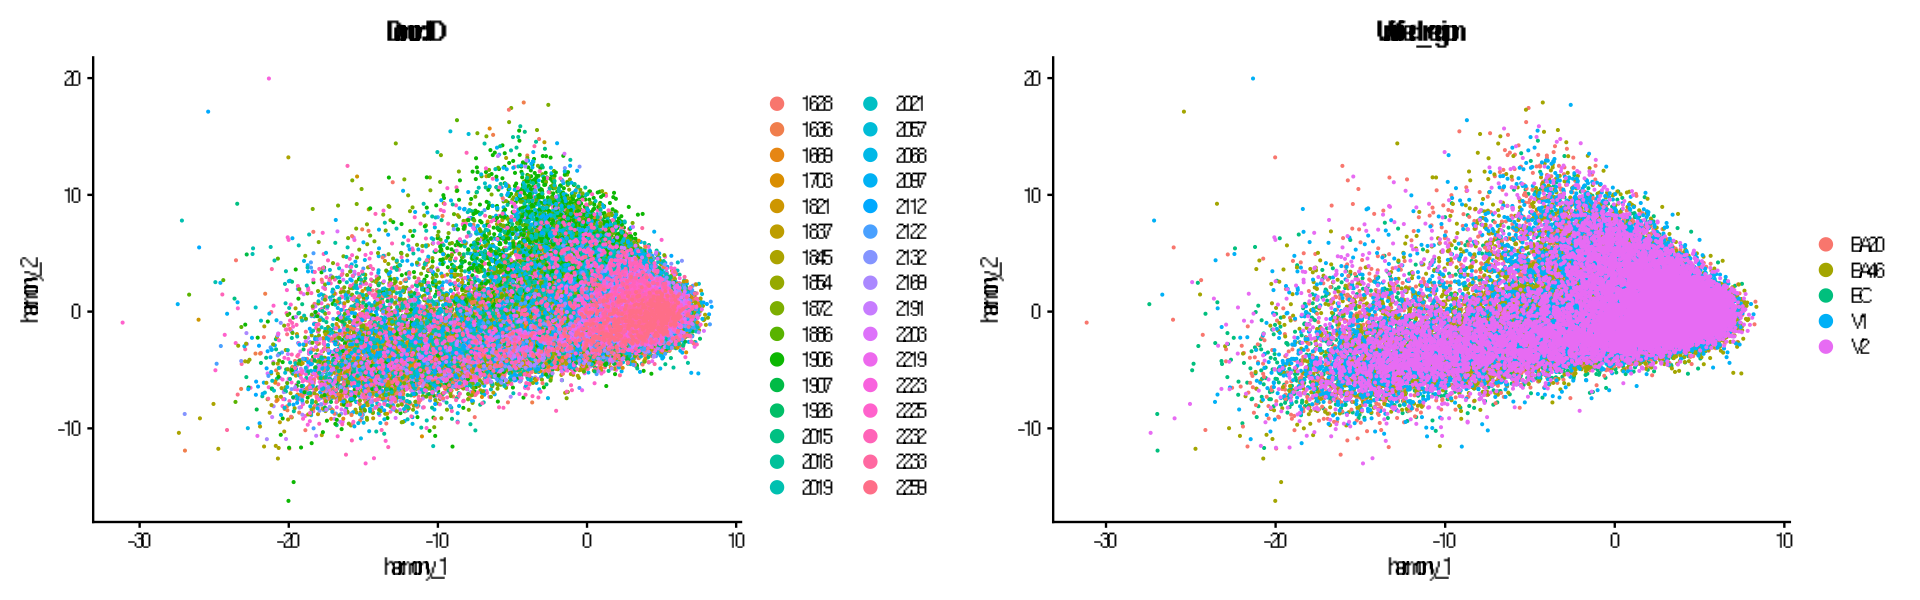

In [12]:
options(repr.plot.height = 5, repr.plot.width = 16)
p2 <- DimPlot(object = ast, reduction = "harmony", pt.size = .1, group.by = "Donor.ID")
p3 <- DimPlot(object = ast, reduction = "harmony", pt.size = .1, group.by = "Unified_region")
plot_grid(p2,p3)

In [13]:
ast <- ast %>% 
    FindNeighbors(reduction = "harmony", dims = 1:20) %>% 
    FindClusters(resolution = 0.3)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 70674
Number of edges: 1619661

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8877
Number of communities: 12
Elapsed time: 20 seconds


1 singletons identified. 11 final clusters.



In [14]:
ast <- ast %>% 
    RunUMAP(reduction = "harmony", dims = 1:20, n_neighbors = 50, seed.use = 42) %>% 
    identity()

Warning message:
“The following arguments are not used: n_neighbors”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:57:40 UMAP embedding parameters a = 0.9922 b = 1.112

14:57:40 Read 70674 rows and found 20 numeric columns

14:57:40 Using Annoy for neighbor search, n_neighbors = 30

14:57:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:57:46 Writing NN index file to temp file /scratch/RtmpQSNWJd/file1b236e610261b1

14:57:46 Searching Annoy index using 1 thread, search_k = 3000

14:58:37 Annoy recall = 100%

14:58:38 Commenci

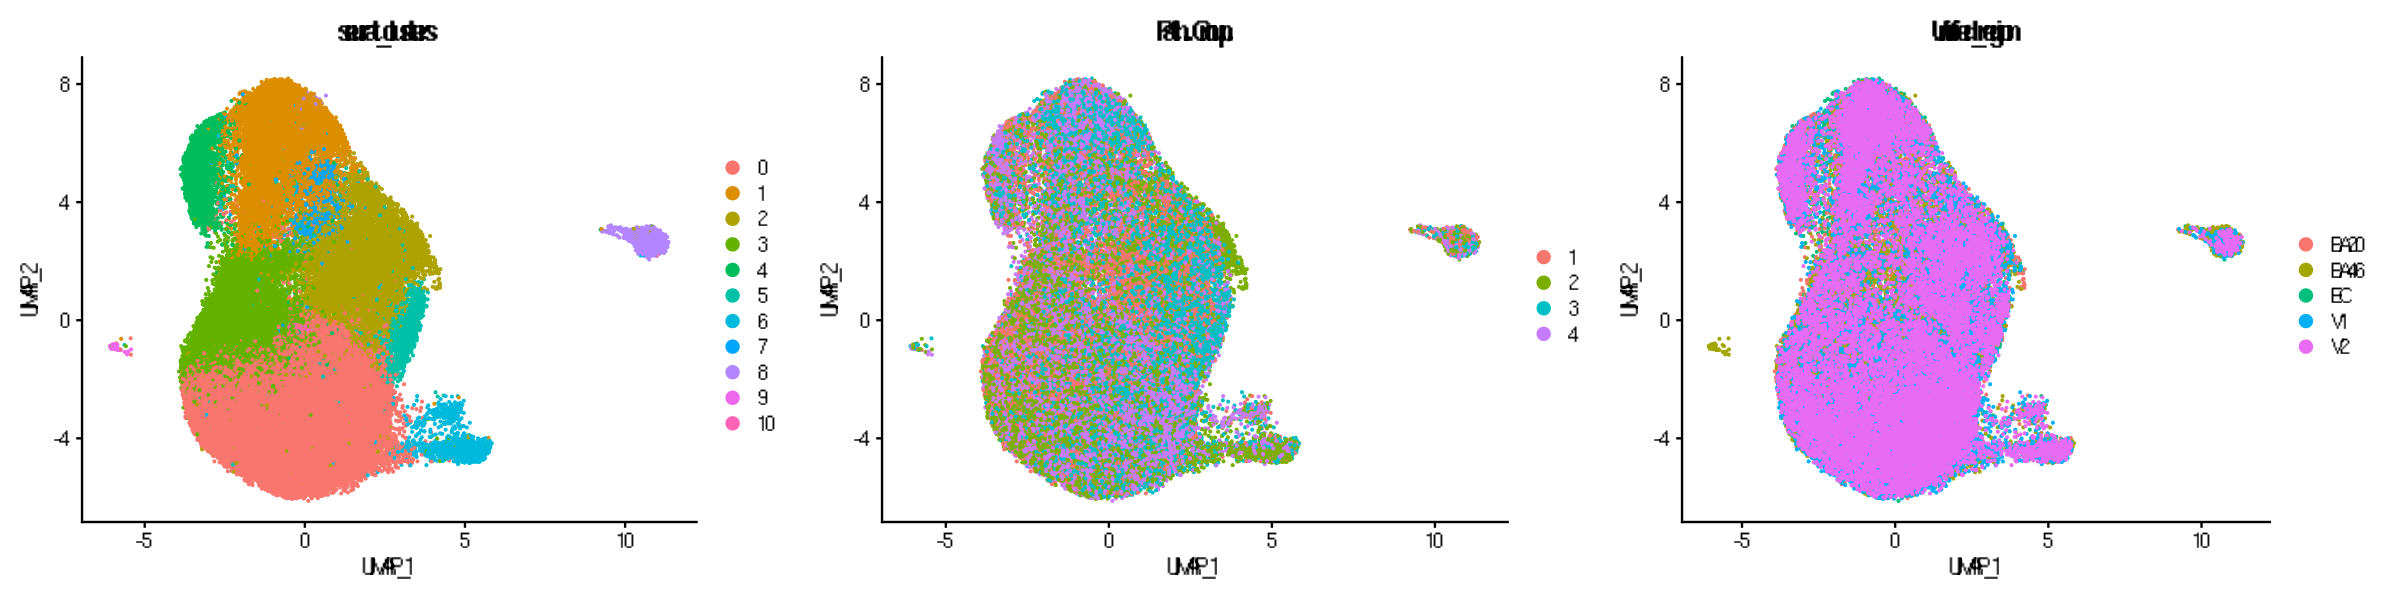

In [15]:
options(repr.plot.height = 5, repr.plot.width = 20)
p1 <- DimPlot(object = ast, reduction = "umap", pt.size = .1, group.by = "seurat_clusters")
p2 <- DimPlot(object = ast, reduction = "umap", pt.size = .1, group.by = "Path..Group.")
p3 <- DimPlot(object = ast, reduction = "umap", pt.size = .1, group.by = "Unified_region")
plot_grid(p1,p2,p3,ncol = 3)

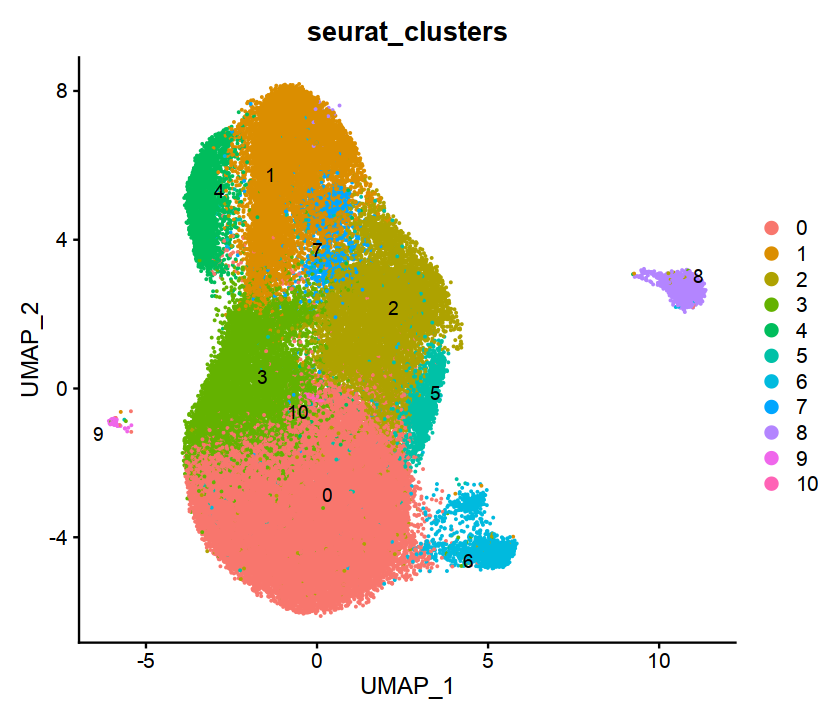

In [17]:
options(repr.plot.height = 6, repr.plot.width = 7)
p1 <- DimPlot(object = ast, reduction = "umap", pt.size = .05, group.by = "seurat_clusters") + 
        theme(text=element_text(size=14,  family="Arial"))
LabelClusters(plot=p1, id = 'seurat_clusters', size = 4, family='Arial')

In [18]:
ast@meta.data$clust_n <- ast@meta.data %>% 
                        group_by(seurat_clusters) %>% 
                        mutate(clust_n = n()) %>% 
                        pull(clust_n)
ast <- ast[,ast$clust_n > 100] ### remove clusters with too few cells

In [9]:
# saveRDS(ast, './seurat_harmony_70674x25802.rds')

### UMAP shape adjusted by rotation

In [4]:
# ast <- readRDS('./seurat_harmony_70674x25802.rds')

In [19]:
### move cluster 8 closer to main body
ast[["umap"]]@cell.embeddings[,1][ast[["umap"]]@cell.embeddings[,1] > 6] <- ast[["umap"]]@cell.embeddings[,1][ast[["umap"]]@cell.embeddings[,1] > 6] - 5

In [20]:
### remove outlier cluster
dim(ast)
ast <- ast[, ast[["umap"]]@cell.embeddings[,1] < 6.5]
ast <- ast[, ast[["umap"]]@cell.embeddings[,1] > (-5)]
dim(ast)

### save org umap locations
ast@meta.data$org.UMAP1 <- Embeddings(ast, "umap")[,1]
ast@meta.data$org.UMAP2 <- Embeddings(ast, "umap")[,2]

### rotate
ast[["umap"]]@cell.embeddings <- ast[["umap"]]@cell.embeddings[, c(2,1)]
colnames(ast[["umap"]]@cell.embeddings) <- c('UMAP_1','UMAP_2')

### flip
ast[["umap"]]@cell.embeddings[, 2] <- -1*ast[["umap"]]@cell.embeddings[, 2]

[1] 25802 70562

[1] 25802 70551

In [21]:
Label_rename = c('c.0' = 'astH0', 'c.6' = 'astNeu', 'c.3' = 'astIM',
                 'c.5' = 'astMet', 'c.2' = 'astTinf', 'c.8' = 'astMic',
                 'c.7' = 'astR0', 'c.1' = 'astR1', 'c.4' = 'astR2')

ast$seurat_clusters_org = paste0('c.', ast$seurat_clusters)
ast$seurat_clusters_renamed <- factor(Label_rename[ast$seurat_clusters_org], 
                                      levels = Label_rename)
Idents(ast) <- ast$seurat_clusters_renamed
levels(Idents(ast))

[1] "astH0"   "astNeu"  "astIM"   "astMet"  "astTinf" "astMic"  "astR0"  
[8] "astR1"   "astR2"

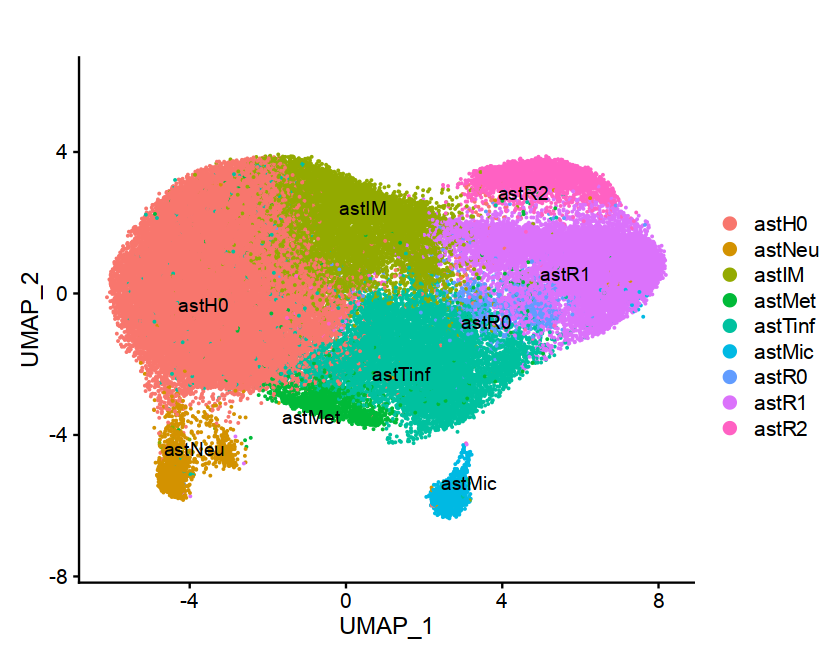

In [23]:
p1 <- DimPlot(object = ast, reduction = "umap", pt.size = .05, group.by = "seurat_clusters_renamed") + 
        theme(text=element_text(size=14,  family="Arial")) +
        ylim(c(-7.5,6)) 
options(repr.plot.height = 5.5, repr.plot.width = 7)
LabelClusters(plot=p1, id = 'seurat_clusters_renamed', size = 4, family='Arial') + ggtitle("")

In [24]:
ast@meta.data$UMAP1 <- Embeddings(ast, "umap")[,1]
ast@meta.data$UMAP2 <- Embeddings(ast, "umap")[,2]
ast@meta.data$clusters = Idents(ast)

In [25]:
# write.csv(ast@meta.data, './seurat_harmony_n70551.csv')
# saveRDS(ast, './ast-500perSamp-Harmony_integrated.for-website.240322.rds')

### FigS9a - Density Map of pathology+region

In [26]:
# ast <- readRDS('./seurat_43702x27275.rds')

In [27]:
library(ggplot2)
library(ggforce)
library(RColorBrewer)
library(viridisLite)

In [28]:
ast@meta.data$UMAP1 <- Embeddings(ast, "umap")[,1]
ast@meta.data$UMAP2 <- Embeddings(ast, "umap")[,2]
dat <- data.frame(ast@meta.data)

In [29]:
dat$Sample <- do.call(paste, c(dat[c('Path..Group.','Unified_region')], sep="-"))

In [30]:
library(stringr)
dat$Sample <- str_replace(dat$Sample, "1-EC", "EC-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-EC", "EC-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-EC", "EC-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-EC", "EC-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-BA20", "ITG-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-BA20", "ITG-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-BA20", "ITG-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-BA20", "ITG-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-BA46", "PFC-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-BA46", "PFC-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-BA46", "PFC-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-BA46", "PFC-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-V2", "V2-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-V2", "V2-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-V2", "V2-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-V2", "V2-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-V1", "V1-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-V1", "V1-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-V1", "V1-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-V1", "V1-PathStage4")

Warning message:
“package ‘stringr’ was built under R version 4.1.3”


In [31]:
dat$Sample <- factor(dat$Sample, levels=paste0(c('EC','ITG','PFC','V2','V1'),
                                               '-PathStage',
                                               c(rep(1,5),rep(2,5),rep(3,5),rep(4,5))))

In [32]:
density_plot <- ggplot(dat, aes(x=UMAP1, y=UMAP2)) +
  stat_density_2d(geom="raster", aes(fill=after_stat(ndensity)), contour=F, bins=100, alpha=100) + #geom=raster;after_stat(ndensity);ndensity calculates the normalized density for each sample--otherwise density would be affected by the number of cells for each sample, which is variable
  scale_fill_gradientn(colours=viridisLite::magma(200), name="nDensity") +
  scale_x_continuous(expand=c(0,0)) +
  scale_y_continuous(expand=c(0,0)) +
  #geom_ellipse(aes(x0=1.7, y0=-2, a=5, b=4, angle = 30), fill=NA,  color = "white", linetype = "dashed")+
  facet_wrap(~Sample, ncol=5) +
  #xlim(-4,6) + 
  ylim(-7.5,6) + 
  theme_classic() +
  theme(strip.background = element_blank(),
        strip.text = element_text(size=14, color="black",family="Arial"),
        axis.text=element_blank(),
        axis.title=element_blank(),
        axis.ticks=element_blank(),
        axis.line = element_blank(),
        plot.background = element_rect(fill = "transparent", color = NA),
        legend.text=element_text(size=12, color="black",family="Arial"),
        legend.title=element_text(size=14, color="black",family="Arial")) +
#guides(color = guide_colorbar(title = "Color Legend")) +
  theme(plot.title = element_text(hjust = 0.1)) +
  theme(legend.position = "bottom") +
  theme(legend.direction = "horizontal") +
  theme(legend.key.height = unit(0.5, "lines")) +
  theme(legend.key.width = unit(7.5, "lines")) +
  theme(legend.title = element_text(size = 14))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [33]:
geom_density_plot <- ggplot(dat, aes(x=UMAP1, y=UMAP2)) +
  geom_point() +
  geom_density_2d(bins = 15, color = "red", linewidth = 2) # thicker for better visibility

# filtered for desired rings (group numbering goes from outermost to innermost
# so we reverse that before filtering for the first four groups, which now
# correspond to the innermost rings)
outline_df <- layer_data(geom_density_plot, 2L) %>% 
  mutate(group = forcats::fct_rev(group)) %>%
  filter(as.integer(group) >= 47)

In [34]:
additional_plot <- ggplot(outline_df, aes(x = x, y = y)) +
  geom_path(aes(group = group), color = "white", linewidth = 0.5) +
  theme_void() +
  ylim(c(-7.5,6))

Warning message:
“Removed 4000 rows containing missing values (`geom_raster()`).”


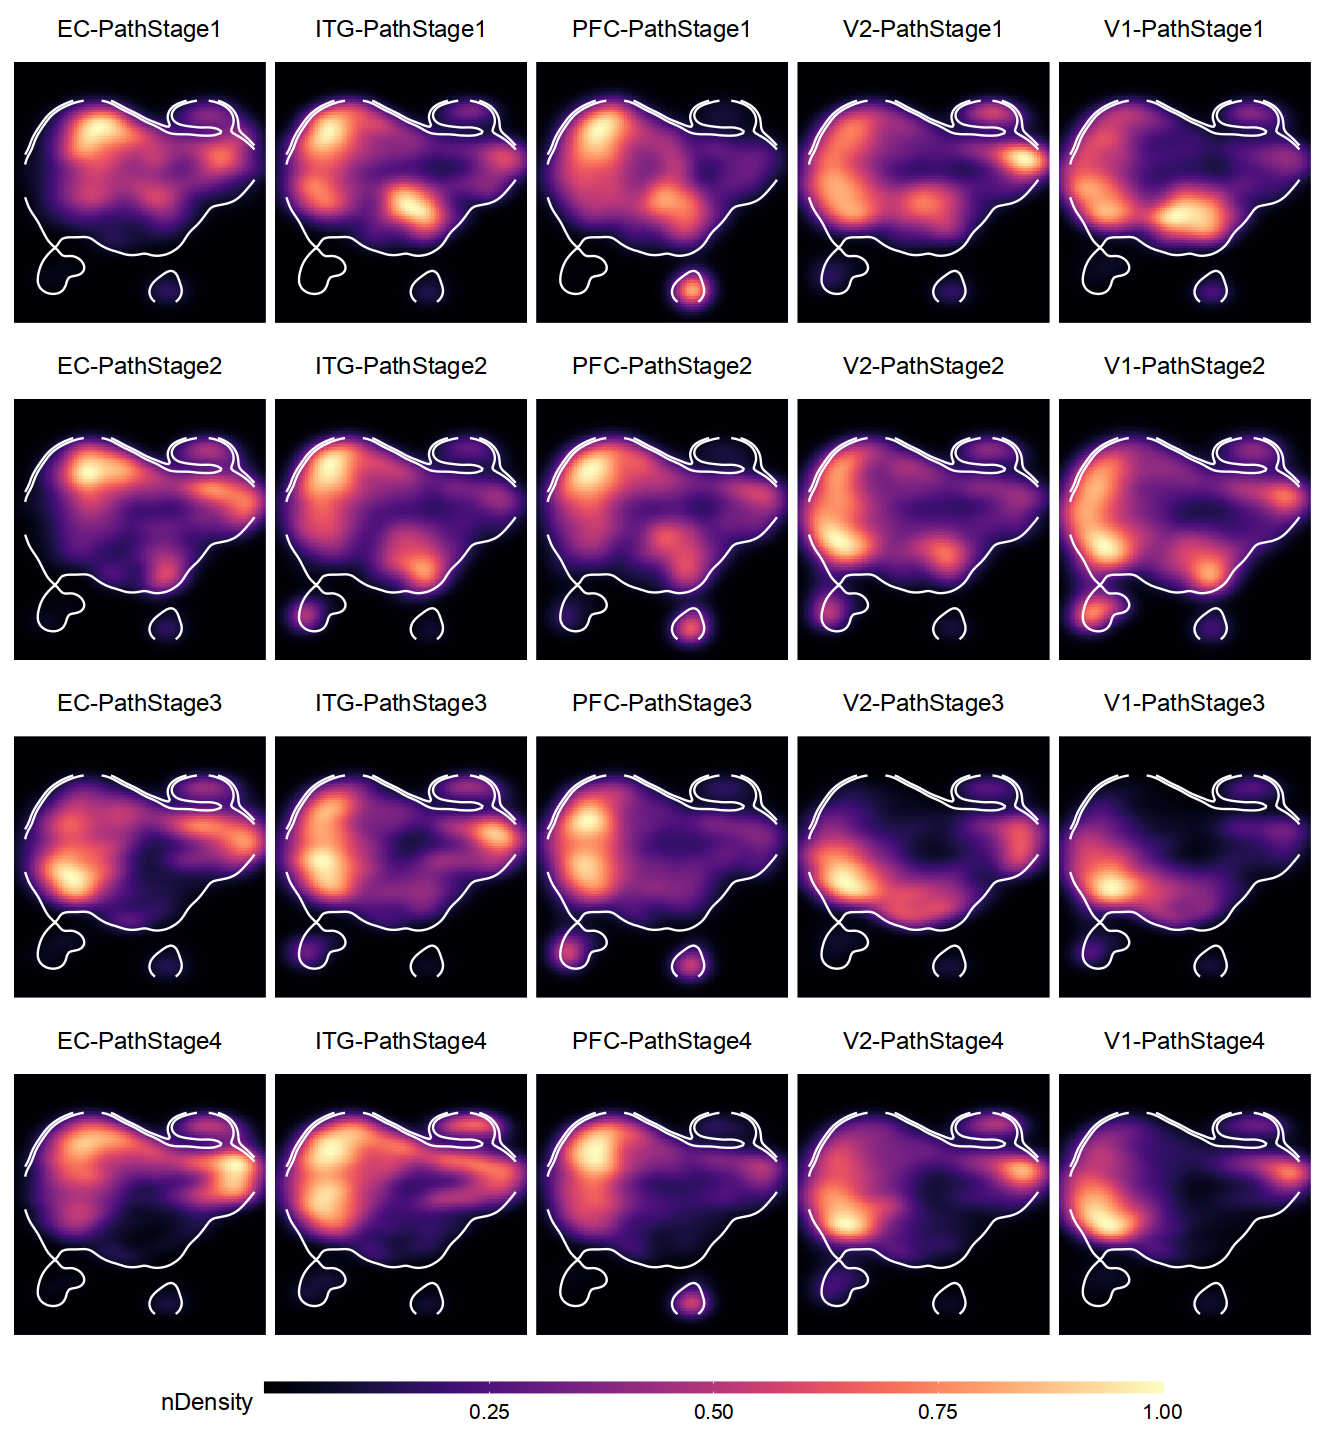

In [35]:
options(repr.plot.height = 12, repr.plot.width = 11)
density_plot +
    annotation_custom(ggplotGrob(additional_plot), xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf)
# ggsave(
#   density_plot, 
#   filename = './Density_plot.png', 
#   height = 11, width = 13)

### FigS9b-c - Spatial-temporal genesets enrichment of sub-cluster

In [36]:
### check data
table(Idents(ast))


  astH0  astNeu   astIM  astMet astTinf  astMic   astR0   astR1   astR2 
  31392    1664    8752    1720   10175    1225    1237   11401    2985 

In [38]:
library(presto)
library(fgsea)
library(tibble)
library(ggplot2)
library(dplyr)
library(limma)

In [39]:
ast@meta.data['old.Idents'] <- Idents(object = ast)

In [40]:
### GSEA need rank all genes, using wilcoxauc which is faster than seurat
ast.genes <- wilcoxauc(ast)
head(ast.genes, 1)

feature    group avgExpr   logFC        statistic auc      pval        
1 AL627309.1 astH0 0.0268765 -0.002341966 610208145 0.496395 4.744696e-07
  padj         pct_in   pct_out 
1 1.040213e-06 3.293833 4.037386

In [41]:
### check if is all genes in all sub-clusters
table(ast.genes$group)


  astH0   astIM  astMet  astMic  astNeu   astR0   astR1   astR2 astTinf 
  25802   25802   25802   25802   25802   25802   25802   25802   25802 

In [42]:
# fgsea_sets <- fgsea::gmtPathways("../genesets/Temporal_trajectory_gene_sets.gmt")
fgsea_sets <- fgsea::gmtPathways("../genesets/Spatial_trajectory_gene_sets.gmt")

In [43]:
fgsea_result = c()
for (grp in unique(ast.genes$group)){
    print(grp)
    ### rank genes of curr grp
    grp.genes <- ast.genes %>%
        dplyr::filter(group == grp) %>%
        arrange(desc(logFC), desc(padj)) %>%  #, desc(auc), # decrease by logFC: desc(logFC)
        dplyr::select(feature, logFC)
    ranks <- deframe(grp.genes)
    ### gsea
    fgseaRes <- fgsea(fgsea_sets, stats = ranks, nPermSimple = 100000)#, nperm = 10000
    grp.fgsea <- fgseaRes %>%
              as_tibble() %>%
              arrange(desc(NES)) %>%
              dplyr::select(-leadingEdge, -ES) %>%  #-nMoreExtreme
              arrange(padj)
    grp.fgsea$Cluster <- grp
    fgsea_result <- rbind(fgsea_result, grp.fgsea)
}

[1] "astH0"
[1] "astNeu"
[1] "astIM"
[1] "astMet"
[1] "astTinf"
[1] "astMic"
[1] "astR0"
[1] "astR1"
[1] "astR2"


In [44]:
fgsea_result$Cluster <- factor(fgsea_result$Cluster, levels = Label_rename)
fgsea_result$pathway <- factor(fgsea_result$pathway, levels = rev(names(fgsea_sets)))

In [45]:
fgsea_result$padj[fgsea_result$padj<1e-4]=1e-4

In [46]:
dot_plot <- ggplot(fgsea_result, aes(x=Cluster, y=pathway)) +
      geom_point(aes(size = padj, fill = NES), color="black", shape=21) +
      scale_size("Padj", trans="log10", range=c(5, 1), breaks=c(1e-4, 1e-3, 1e-2, 1e-1,0.5)) +
      scale_fill_gradientn(colours = colorRampPalette(c('navy','white','darkred'), bias=1)(20),#viridisLite::mako(100),
                       guide = guide_colorbar(ticks.colour = "black",
                                              frame.colour = "black"),
                       name = "NES") +
      ylab("Spatial Gene Set") + xlab("Astrocyte sub-cluster") + #Temporal，Spatial
      theme_bw() +
      theme(axis.text.x = element_text(size=12, angle=45, hjust=1, color="black",family='Arial'),
            axis.text.y = element_text(size=12, color="black",family='Arial'),
            axis.title = element_text(size=14,family='Arial'),
            legend.title=element_text(size=14, color="black",family="Arial"),
           panel.grid=element_blank())

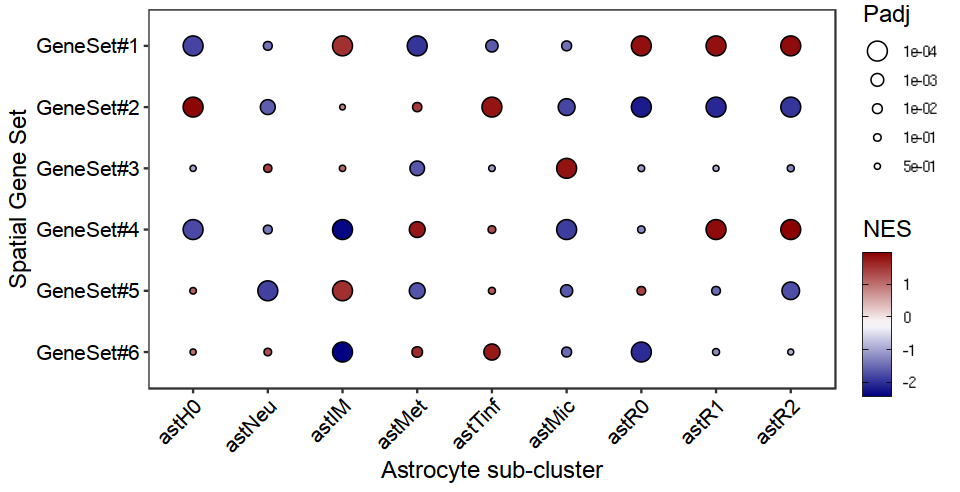

In [47]:
options(repr.plot.width = 8, repr.plot.height = 4.1)
dot_plot

### Fig6 - Proportion change of each sub-cluster

In [49]:
library(stringr)
library(RColorBrewer)
library("PupillometryR")
cb_palette <- "Paired"

In [50]:
donor_meta <- read.csv('../../../data/sample_metadata.csv')
dim(donor_meta)
head(donor_meta,1)

[1] 146  11

Donor.ID Region Ptau.Total.Tau..A.U.. abeta_3D6 Path..Group. Sex Age Braak A
1 1628     EC     0.6443258             3.548348  4            F   60  VI    3
  B C
1 3 3

In [51]:
my_theme <- theme(strip.background = element_blank(),
            strip.text = element_text(size = 12),  # Adjust the facet title font size here
            text=element_text(size=12,  family="Arial"), #sans
            axis.text.x = element_text(size=12),
            axis.text.y = element_text(size=12),
            axis.title.x = element_text(size=12),
            axis.title.y = element_text(size=12),
            legend.position = "right")

In [52]:
# ast <- readRDS('./seurat_harmony_70674x25802.rds')

In [53]:
ast_meta <- merge(ast@meta.data[c('SampleName','Donor.ID','Path..Group.','Unified_region')], donor_meta,
                 by.x=c('Donor.ID','Unified_region','Path..Group.'), 
                 by.y=c('Donor.ID','Region','Path..Group.'),
                 all.x=T)
table(unique(ast_meta[c('Donor.ID','Path..Group.','Sex')])[c('Path..Group.','Sex')])

            Sex
Path..Group. F M
           1 4 4
           2 5 3
           3 6 2
           4 4 4

In [54]:
clust_proportion_df <- ast@meta.data %>% 
                        group_by(SampleName) %>% 
                        mutate(samp_n = n()) %>% 
                        group_by(SampleName, seurat_clusters_renamed) %>% 
                        mutate(samp_clust_n = n()) %>% 
                        mutate(samp_clust_percent = samp_clust_n/samp_n) %>% 
                        select(SampleName, Unified_region, Path..Group., samp_n, 
                               seurat_clusters_renamed, samp_clust_n, samp_clust_percent) %>% 
                        distinct()
head(clust_proportion_df,1)

SampleName   Unified_region Path..Group. samp_n seurat_clusters_renamed
1 6289-MW-0031 EC             1            386    astH0                  
  samp_clust_n samp_clust_percent
1 66           0.1709845

In [55]:
clust_proportion_df$Unified_region <- str_replace(clust_proportion_df$Unified_region, "BA20", "ITG")
clust_proportion_df$Unified_region <- str_replace(clust_proportion_df$Unified_region, "BA46", "PFC")
clust_proportion_df$Unified_region <- factor(clust_proportion_df$Unified_region, 
                                            levels=c('EC', 'ITG', 'PFC', 'V2', 'V1'))
table(clust_proportion_df$Unified_region)


 EC ITG PFC  V2  V1 
193 267 243 267 272 

In [56]:
clust_proportion_df$seurat_clusters <- factor(clust_proportion_df$seurat_clusters_renamed,
                                        levels = sort(unique(clust_proportion_df$seurat_clusters_renamed)))
levels(clust_proportion_df$seurat_clusters)

[1] "astH0"   "astNeu"  "astIM"   "astMet"  "astTinf" "astMic"  "astR0"  
[8] "astR1"   "astR2"

In [57]:
### Kruskal-Wallis test
p_values <- lapply(clust_proportion_df$seurat_clusters, function(i) {
              kruskal_result <- kruskal.test(samp_clust_percent ~ Path..Group.,  ###
                                             data = subset(clust_proportion_df, seurat_clusters == i))
              paste("p =", format(kruskal_result$p.value, digits = 2))
})
clust_proportion_df$kruskal.test <- p_values

In [58]:
clust_proportion_df$sub_plot_name <- paste0(clust_proportion_df$seurat_clusters, "\n",
                                            "(Kruskal-Wallis, ", p_values, ")")

order_df = unique(clust_proportion_df[,c('seurat_clusters','sub_plot_name')])
rownames(order_df) <- order_df$seurat_clusters
order_df = order_df[levels(clust_proportion_df$seurat_clusters),]
### set levels
clust_proportion_df$sub_plot_name <- factor(clust_proportion_df$sub_plot_name,
                                           levels=order_df$sub_plot_name)

Warning message:
“Setting row names on a tibble is deprecated.”


In [59]:
require(scales)
col_palette = hue_pal()(9)

Loading required package: scales



Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


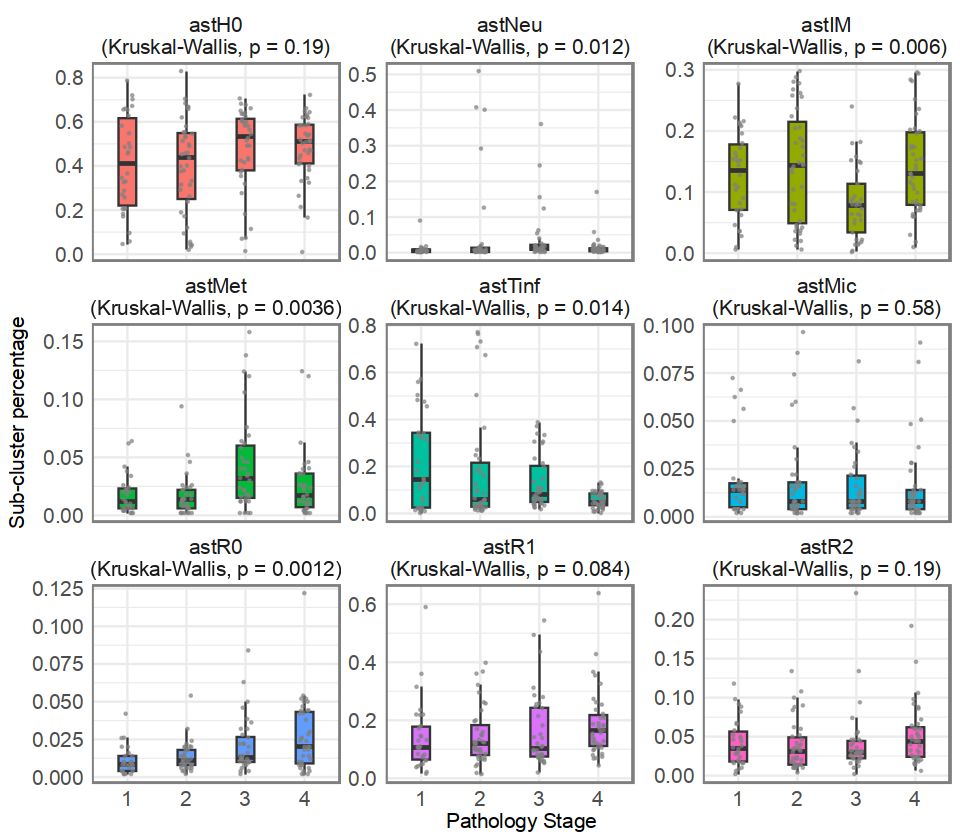

In [60]:
options(repr.plot.height = 7, repr.plot.width = 8)
p <- ggplot(clust_proportion_df, aes(x=Path..Group., y=samp_clust_percent, fill=sub_plot_name)) +
  geom_boxplot(width = .3, outlier.shape = NA) + #, alpha = 0.5
  geom_jitter(width = 0.1, size = 0.25, shape = 19, stroke = 0.5, color = 'gray50', alpha=0.6) + 
  facet_wrap(sub_plot_name ~ ., scales = "free_y", ncol = 3) + 
  theme_minimal() + my_theme  +
  labs(x = "Pathology Stage", y = "Sub-cluster percentage") +
  theme(panel.border = element_rect(color = "gray50", fill = NA, size = 1))+
  #scale_fill_brewer(palette=col_palette) + scale_color_brewer(palette=col_palette) +
  scale_fill_manual(values = col_palette) + scale_color_manual(values = col_palette) +
  theme(legend.position="none")
p

In [61]:
### Kruskal-Wallis test
p_values <- lapply(clust_proportion_df$seurat_clusters, function(i) {
              kruskal_result <- kruskal.test(samp_clust_percent ~ Unified_region,  ###
                                             data = subset(clust_proportion_df, seurat_clusters == i))
              paste("p =", format(kruskal_result$p.value, digits = 2))
})
clust_proportion_df$kruskal.test <- p_values

In [63]:
clust_proportion_df$sub_plot_name <- paste0(clust_proportion_df$seurat_clusters,"\n",
                                            "(Kruskal-Wallis, ", p_values, ")")
order_df = unique(clust_proportion_df[,c('seurat_clusters','sub_plot_name')])
rownames(order_df) <- order_df$seurat_clusters
order_df = order_df[levels(clust_proportion_df$seurat_clusters),]
### set levels
clust_proportion_df$sub_plot_name <- factor(clust_proportion_df$sub_plot_name,
                                           levels=order_df$sub_plot_name)

Warning message:
“Setting row names on a tibble is deprecated.”


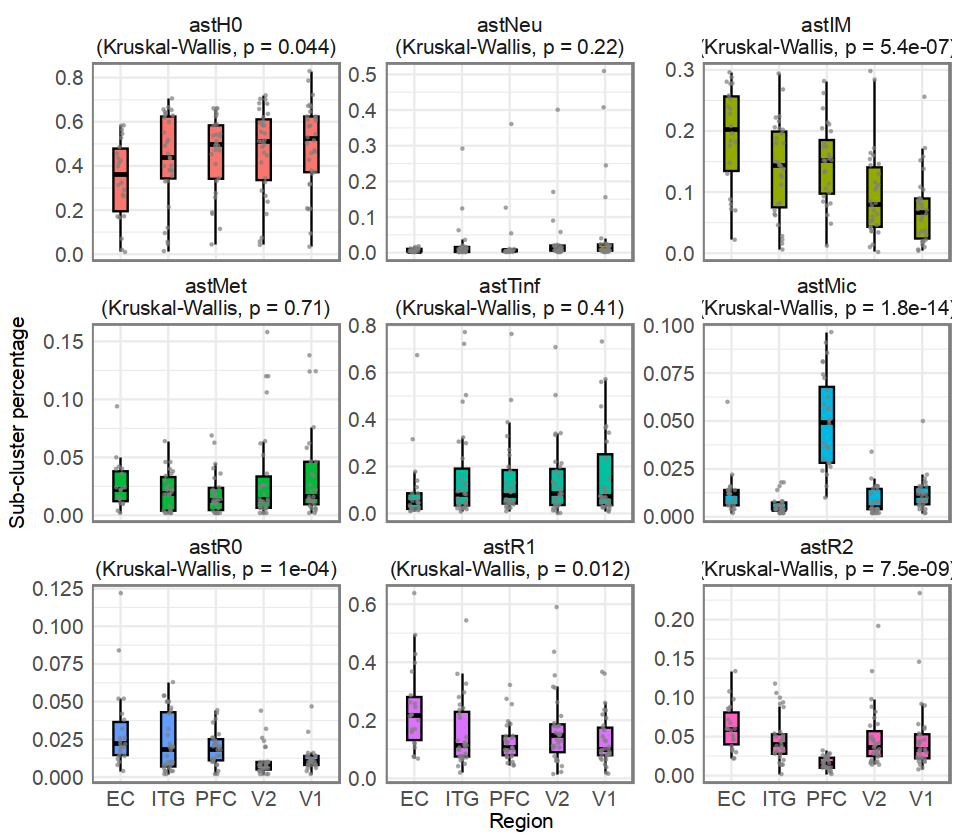

In [64]:
options(repr.plot.width = 8, repr.plot.height = 7)
p <- ggplot(data = clust_proportion_df, aes(x = Unified_region, y = samp_clust_percent, fill = sub_plot_name)) +
  geom_boxplot(color = "black", width = 0.3, outlier.shape = NA) +  
  geom_jitter(width = 0.1, size = 0.25, shape = 19, stroke = 0.5, color = 'gray50', alpha=0.6) + 
  facet_wrap(~sub_plot_name, ncol = 3, scales = "free_y") +
  theme_minimal() + my_theme +
  labs(x = "Region", y = "Sub-cluster percentage") +
  theme(panel.border = element_rect(color = "gray50", fill = NA, size = 1))+
  scale_fill_manual(values = col_palette) +
  theme(legend.position="none")
p

### Fig6 - Pseudo-time and heatmap along pseudotime

In [66]:
library(monocle3)
packageVersion("monocle3")
library(scales)

[1] ‘1.3.1’

build monocle obj

In [67]:
## genes meta
gene_annotation <- as.data.frame(rownames(ast@reductions[["pca"]]@feature.loadings), 
                                 row.names = rownames(ast@reductions[["pca"]]@feature.loadings))
colnames(gene_annotation) <- "gene_short_name"
head(gene_annotation,1)

## cells meta
cell_metadata <- as.data.frame(ast@assays[["RNA"]]@counts@Dimnames[[2]], 
                               row.names = ast@assays[["RNA"]]@counts@Dimnames[[2]])
colnames(cell_metadata) <- "barcode"
head(cell_metadata,2)

## count matrix
New_matrix <- ast@assays[["RNA"]]@counts
New_matrix <- New_matrix[rownames(ast@reductions[["pca"]]@feature.loadings), ]
expression_matrix <- New_matrix

gene_short_name
AC006387.1 AC006387.1

barcode                        
AAACCCACAGGTGTTT-1_6289-MW-0031 AAACCCACAGGTGTTT-1_6289-MW-0031
AAACGAAGTTAATGAG-1_6289-MW-0031 AAACGAAGTTAATGAG-1_6289-MW-0031

In [68]:
cds_from_seurat <- new_cell_data_set(expression_matrix,
                                     cell_metadata = cell_metadata,
                                     gene_metadata = gene_annotation)

Construct and assign the made up partition

In [69]:
recreate.partition <- c(rep(1, length(cds_from_seurat@colData@rownames)))
names(recreate.partition) <- cds_from_seurat@colData@rownames
recreate.partition <- as.factor(recreate.partition)

cds_from_seurat@clusters@listData[["UMAP"]][["partitions"]] <- recreate.partition

Assign the cluster info

In [70]:
cluster.res <- 0.3
nPC <- 20
ast[[sprintf("ClusterNames_%.1f_%dPC", cluster.res, nPC)]] <- Idents(object = ast)
list_cluster <- ast@meta.data[[sprintf("ClusterNames_%s_%sPC", cluster.res, nPC)]]
names(list_cluster) <- ast@assays[["RNA"]]@data@Dimnames[[2]]

cds_from_seurat@clusters@listData[["UMAP"]][["clusters"]] <- list_cluster

In [71]:
### Could be a space-holder, but essentially fills out louvain parameters
cds_from_seurat@clusters@listData[["UMAP"]][["louvain_res"]] <- "NA"

In [72]:
### Assign UMAP coordinate
cds_from_seurat@int_colData@listData$reducedDims@listData[["UMAP"]] <-ast@reductions[["umap"]]@cell.embeddings 

Learn graph

In [94]:
print("Learning graph, which can take a while depends on the sample")
cds_from_seurat <- learn_graph(cds_from_seurat, use_partition = T)

[1] "Learning graph, which can take a while depends on the sample"
  |======================================================================| 100%


In [95]:
colData(cds_from_seurat)$cell_type <- ast@meta.data[rownames(colData(cds_from_seurat)),]$seurat_clusters_renamed

In [96]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, time_bin='astH0'){
  cell_ids <- which(colData(cds)[, "cell_type"] == time_bin)
  
  closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
          igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
                  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

In [97]:
cds_from_seurat <- order_cells(cds_from_seurat, 
                               root_pr_nodes = get_earliest_principal_node(cds_from_seurat))

Cells aren't colored in a way that allows them to be grouped.



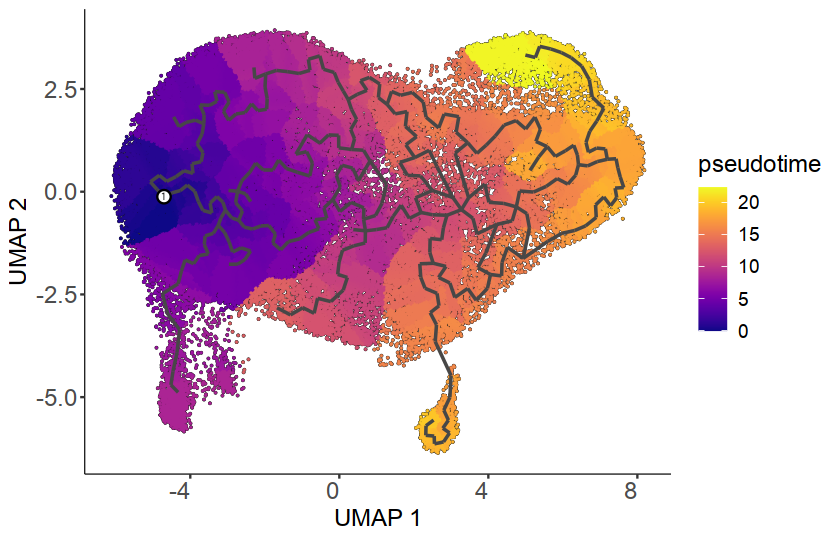

In [98]:
options(repr.plot.width = 7, repr.plot.height = 4.5)
ptime <- plot_cells(cds_from_seurat, 
                color_cells_by = 'pseudotime',
                label_cell_groups = TRUE,
                label_groups_by_cluster = TRUE,
                label_leaves = FALSE,
                label_branch_points=FALSE) + 
        theme(text=element_text(size=14,  family="Arial")) +
        theme(axis.text = element_text(size = 14, hjust = 1))
#LabelClusters(plot=ptime, id = 'cell_type')
ptime

In [99]:
suppressPackageStartupMessages(library(monocle3))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(data.table))

In [100]:
h1 = c('CTNNA2','EFNA5','FGFR2','HPSE2','IGF1R','KCNMA1','MBNL2','NFE2L2','NRF1','NRG2')
h2 = c('AKAP9','BCL2','ETNPPL','GLUD1','MT-ATP6','MT-CO1','MT-CO2','MT-CO3','MT-ND1','MT-ND3','RBMS3')
h1h2 = c('ALDH1L1','CD47','EGFR','EGLN3','ERBB4','GJA1','GLUL','GRM3',
       'HIF3A','LRP1','MEGF10','NFIA','NFIB','NRXN1','NTRK3','PON2',
        'PTN','RYR3','SLC1A2','SLC1A3','SYNE1')
r1 = c('ADAMTSL3','AQP1','CAMK2D','GAB1','IRS2','LONP2','MAP4K3','SOD2','SORT1')
r2 = c('EZR','GAREM1','GRIA1','LRIG1','MAPK1','MARK3','PRKCA','TRA2A','TRAK1')
r1r2 = c('ACTB','APP','AQP4','CD44','CLU','CRYAB','ECE1','FGFR1',
       'GFAP','HSPB1','HSPB8','LAMA1','MAOB','MAP1B','MAPT','MT1E',
       'MT2A','PRDX6','S100B','VCAN')
asp_add = c('HSPH1','SERPINA3','ABCA1','C3')#'MT1H'

subset of sub-clusters

In [119]:
cds <- cds_from_seurat
colData(cds)$SampleName <- ast@meta.data[rownames(colData(cds)),]$SampleName
colData(cds)$Donor.ID <- ast@meta.data[rownames(colData(cds)),]$Donor.ID

In [120]:
### only subset of cds
cds <- cds[,colData(cds)$cell_type %in% c('astH0','astTinf','astR1')]
cds <- cds[, colnames(subset(ast[,rownames(colData(cds))], downsample = 3000))] ## subset sample number cell from each subtype
dim(cds)

[1] 2000 9000

variable genes for heatmap to check continumm

In [121]:
### genes change along pseudotime/graph
pr_graph_test_res <- graph_test(cds, neighbor_graph="knn", cores=8)
pr_deg_ids <- row.names(subset(pr_graph_test_res, q_value < 1e-5))
length(pr_deg_ids)

  |=======================================================| 100%, Elapsed 00:05


[1] 1183

In [122]:
genes <- c(h1,h2,h1h2,r1,r2,r1r2,pr_deg_ids) #pr_deg_ids, variable_features, markers
genes <- genes[genes %in% rownames(cds)]
length(genes)

[1] 1205

In [123]:
### order cells by pseudotime
order_ = order(colData(cds)$cell_type, pseudotime(cds))
cds@colData$Clust <- cds@colData$cell_type
cds@colData$pseudotime <- pseudotime(cds)[rownames(cds@colData)]
colData <- cds@colData[order_,]

col ann for heatmap

In [124]:
col_palette <- hue_pal()(9)

In [125]:
ann <- data.frame(colData$Clust)
colnames(ann) <- c('Clusters')
colours <- list('Clusters' = setNames(col_palette[1:9], levels(colData$Clust)))

colAnn <- HeatmapAnnotation(
    df = data.frame(ann),
    which = 'col',
    col = colours,
    annotation_width = unit(c(1, 4), 'cm'),
    gap = unit(1, 'mm'),
    show_legend = FALSE,
    show_annotation_name = T)

In [126]:
ann_ <- data.frame(colData$pseudotime)
colnames(ann_) <- c('Pseudotime')
min_v = min(colData$pseudotime)
max_v = max(colData$pseudotime)
nrow = dim(ann_)[1]
Var = viridisLite::magma(nrow)#circlize::colorRamp2(seq(min_v, max_v, length = nrow), viridisLite::viridis(nrow))
names(Var) <- colData$pseudotime

pseudotime_annot = HeatmapAnnotation(df = ann_,
                            col = list('Pseudotime'=Var),
                            which = "col",
                            show_legend = FALSE,
                            show_annotation_name = T)

matrix for heatmap: pt.matrix

In [127]:
order_cells_ = names(pseudotime(cds)[order_])
mat_ <- as.matrix(GetAssayData(ast, assay = 'RNA')[match(genes, rownames(ast)), order_cells_]) #######check here

pt.matrix <- mat_
pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=5)$y}))
pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))

rownames(pt.matrix) <- genes
colnames(pt.matrix) <- colnames(mat_)
dim(pt.matrix)

[1] 1205 9000

In [128]:
identical(rownames(colData), colnames(pt.matrix)); identical(rownames(pt.matrix), genes)

[1] TRUE

[1] TRUE

In [129]:
### reorder rows by column max from left to right
gene_list=c()
argmax_cell=c()
for (i in seq(1,dim(pt.matrix)[1])){
    gene_list = c(gene_list, rownames(pt.matrix)[i])
    argmax_cell = c(argmax_cell, names(which.max(pt.matrix[i,])))
} 

resort_mat = data.frame('gene'=gene_list,
                        'argmax_cell'=argmax_cell,
                        'pseudotime'=pseudotime(cds)[argmax_cell])

resort_genes = resort_mat[order(resort_mat$pseudotime, decreasing = F),]$gene

In [130]:
hp_color = colorRamp2(seq(from=-2,to=2,length=11),rev(brewer.pal(11, "Spectral")))#RdBu
hp_color_pt = colorRamp2(seq(from=min(pseudotime(cds)),to=max(pseudotime(cds)),length=11),
                      rev(colorRampPalette(brewer.pal(11, "RdYlBu"))(11)))

In [131]:
pt.matrix = pt.matrix[resort_genes,]
pt.matrix = pt.matrix[!duplicated(rownames(pt.matrix)),]
pt.matrix = pt.matrix[!rownames(pt.matrix) %in% c('MT-ATP6','MT-CO1','MT-CO2','MT-CO3',
                                      'MT-ND1','MT-ND2','MT-ND3','MT-ND4','MT-ND5',
                                      'MT-CYB','MT-ND4L'),]

In [132]:
### Legend
lgd = packLegend(
    Legend(title = "Z-score", at = c(-2, 0, 2), 
           legend_gp = gpar(fill = -2:2),
           col_fun = hp_color,
           title_gp = gpar(fontsize = 12), 
           labels_gp = gpar(fontsize = 12)),
    Legend(title = "Clusters", 
           at = names(colours$Clust), 
           legend_gp = gpar(fill = colours$Clust)))

In [133]:
h_m = h1h2
r_m = c(r1r2,asp_add)


label_color1 = rep('blue',length(h1h2))
names(label_color1) <- c(h1h2)
label_color2 = rep('red',length(r_m))
names(label_color2) <- c(r_m)
label_color = c(label_color1,label_color2)

real plot

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



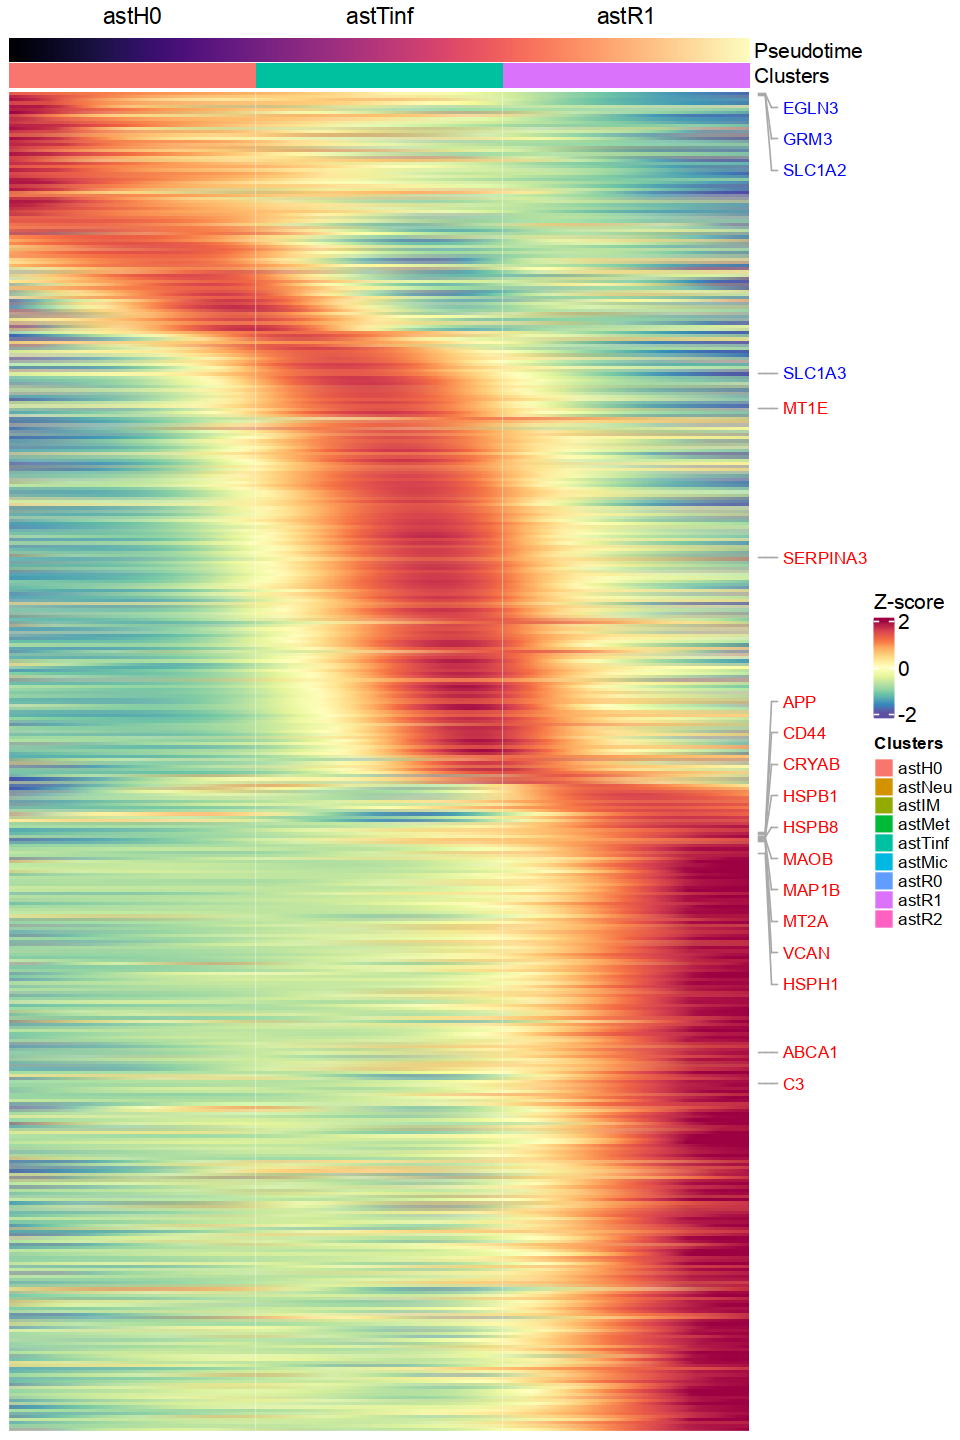

In [134]:
options(repr.plot.width=8, repr.plot.height=12)
pushViewport(viewport(gp = gpar(fontfamily = "Arial")))
ht <- Heatmap(
  pt.matrix,
  ### row cluster
  cluster_rows                 = FALSE, #row_dend, 
  show_row_dend                = FALSE,
  cluster_row_slices           = FALSE,
  cluster_columns              = FALSE,
  show_row_names               = FALSE,
  show_column_names            = FALSE,
  row_names_gp                 = gpar(fontsize = 6),
  #km                           = 3,
  #column_km = 6,
  column_split                 = colData$cell_type,
  column_gap                   = unit(0.1, "mm"),
  cluster_column_slices        = FALSE,
  # annot
  row_title_rot                = 90,
  top_annotation               = c(pseudotime_annot, colAnn),
  col                          = hp_color,
  show_heatmap_legend          = FALSE) + 
  # gene name annot
  rowAnnotation(link = anno_mark(at = which(rownames(pt.matrix) %in% c(h_m,r_m)), 
                labels = rownames(pt.matrix)[which(rownames(pt.matrix) %in% c(h_m,r_m))], #c(h_m,r_m), 
                labels_gp = gpar(fontsize = 10,
                            col=label_color[rownames(pt.matrix)[which(rownames(pt.matrix) %in% c(h_m,r_m))]]), 
                lines_gp = gpar(col='darkgrey'),
                padding = unit(1, "mm")))

ht <- draw(ht, 
           annotation_legend_list = lgd, 
           newpage = FALSE, 
           merge_legend = TRUE)
popViewport()

### Fig5 - subcluster Markers

In [73]:
levels(Idents(object = ast))

[1] "astH0"   "astNeu"  "astIM"   "astMet"  "astTinf" "astMic"  "astR0"  
[8] "astR1"   "astR2"

In [74]:
# cluster.markers <- FindAllMarkers(ast, min.pct = 0.1, test.use = 'LR', latent.vars = 'SampleName')
# write.csv(cluster.markers, './ast_cluster_markers_by_FindAllMarkers-LR.csv')

In [76]:
cluster.markers <- read.csv('./Markers/ast_cluster_markers_by_FindAllMarkers-LR.csv')
head(cluster.markers,1)

X    p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene
1 SGCD 0     1.009947   0.903 0.756 0         0_astH  SGCD

In [77]:
my_border_theme = function(){
  theme(
    axis.line.x = element_line(color = "black"),
    axis.line.y = element_line(color = "black"),
    panel.background = element_rect(fill = "white", color = NA),
    plot.background = element_rect(fill = "white", color = NA),
    strip.background =element_rect(fill="white"),
    axis.title.x = element_text(
      margin = margin(0.1, 0, 0, 0, unit = "cm"),
      size = 15
    ),
    axis.title.y = element_text(
      margin = margin(0, 0.1, 0, 0, unit = "cm"),
      angle =90, 
      size = 15
    ),
    axis.text.x = element_text(color = "black", size = 16),
    axis.text.y = element_text(color = "black", size = 14),
    legend.key = element_rect(fill = "white"),
    legend.background = element_rect(fill="white"),
    panel.border = element_rect(
      colour = "black", 
      fill=NA, 
      size=1
    ),
    plot.title = element_text(hjust = 0.5, size = 15)
  )
}

In [79]:
### markers of interest
cherrypick = read.csv('./Markers/ast_cluster_markers_by_FindAllMarkers-LR_asp_top5.csv')
cherrypick = merge(cherrypick, cluster.markers, 
                   by.x=c('gene', 'cluster'),  by.y=c('gene','cluster'), all.x=T, sort = FALSE)
gene_order = cherrypick %>% arrange(cluster, gene) %>% pull(gene)

In [80]:
avge = DotPlot(ast, features=rev(unique(cherrypick$gene)))$data %>%
                as.data.frame() 
avge$features.plot <- factor(avge$features.plot, levels = rev(gene_order))
avge$Clusters <- factor(avge$id, levels = unique(avge$id))

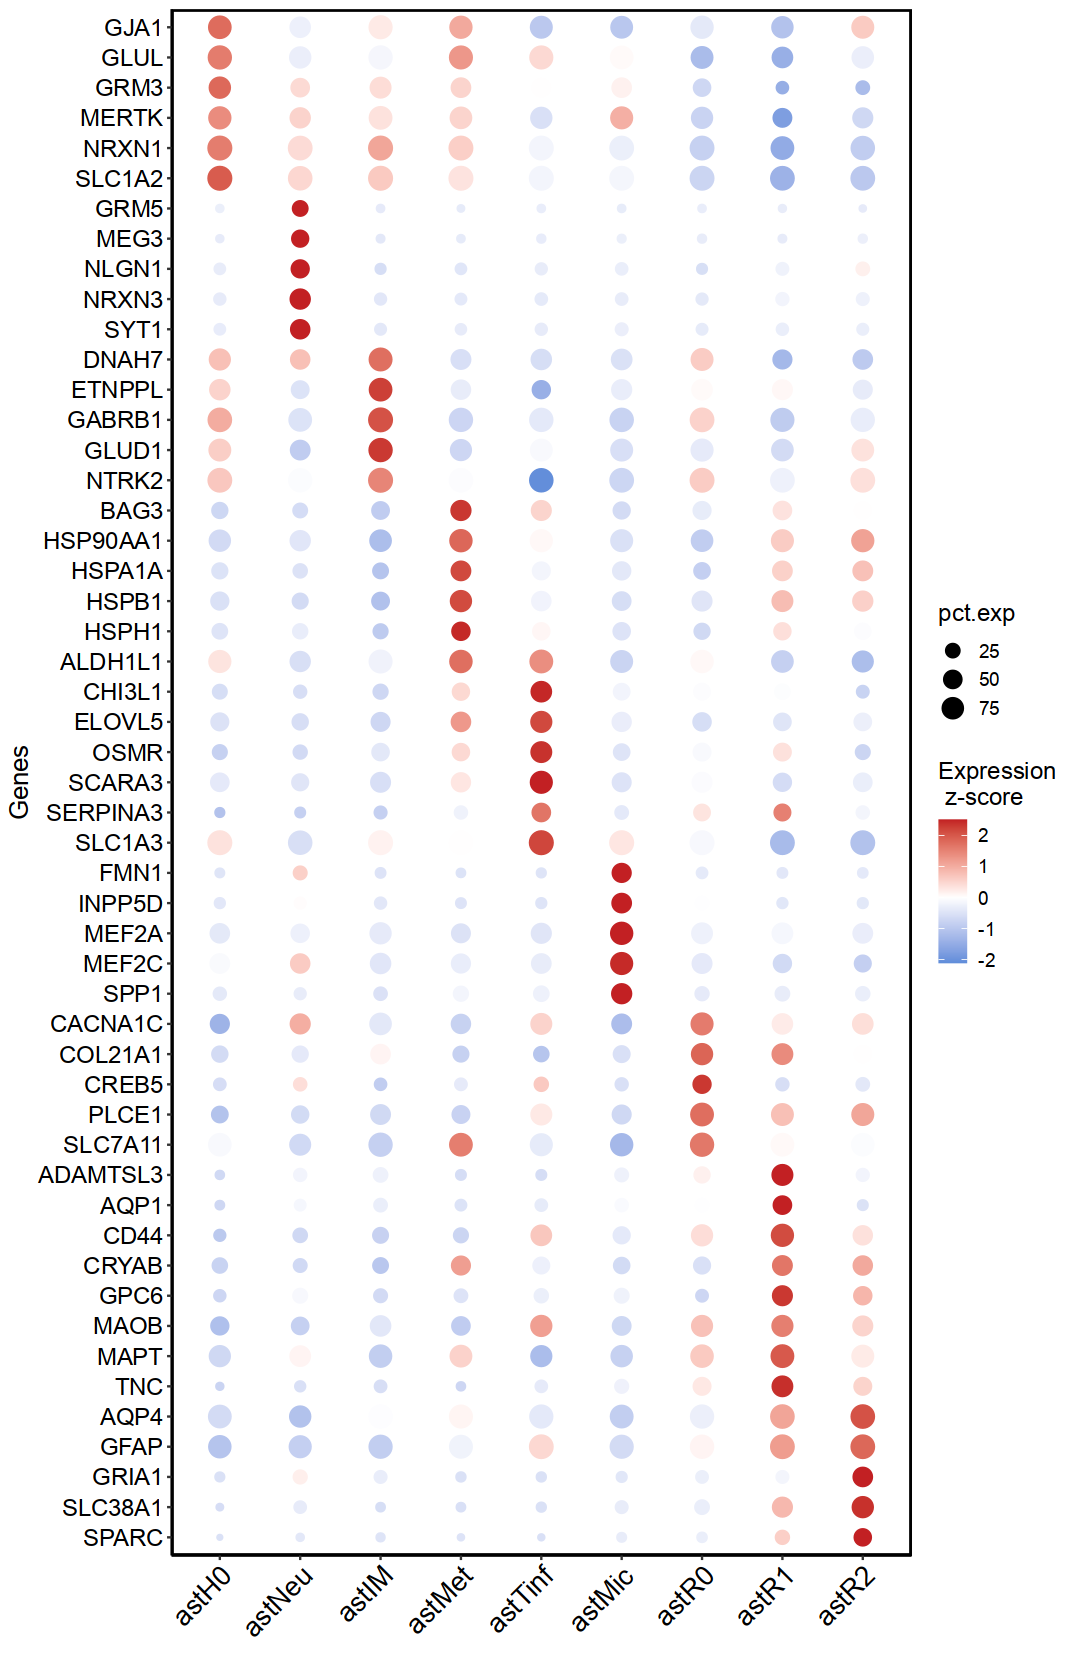

In [81]:
options(repr.plot.width = 9, repr.plot.height = 14)
ggplot(avge, aes(
     x = Clusters, y = features.plot, 
     color = avg.exp.scaled, size = pct.exp)
    ) + 
geom_point() +
scale_color_gradient2(
        name = "Expression \n z-score", 
        low="#2F79D2",
        mid="white",
        high="#C22023", na.value = "gray", 
        midpoint = 0,
        limits = c(-2.1, 2.5)
      ) +
scale_size(
        range = c(1, 6),
        breaks = c(25, 50, 75, 100)
     ) +
     #facet_grid(id ~ ., space = "free", scales = "free") +
     my_border_theme() +
     theme(text=element_text(size=14,  family="Arial")) +
     theme(axis.text.x = element_text(angle = 45, hjust=1)) +
     labs(x="", y = "Genes")

### Fig5 - Pathway analysis

In [39]:
library(data.table)
library(org.Hs.eg.db)
library(clusterProfiler)
library(ReactomePA)
library(enrichplot)
library(ggplot2)
library(gridExtra)
# library(WriteXLS)

In [40]:
markers <- fread("ast_cluster_markers_by_FindAllMarkers-LR.csv")
markers <- markers[p_val_adj < 0.05 & avg_log2FC > 0.25]
markers <- markers[order(cluster, -avg_log2FC )]

In [41]:
clust_rename = setNames(Label_rename, sort(unique(markers$cluster)))
markers$cluster = clust_rename[markers$cluster]

Run pathways analysis with top 200 marker genes
Reactome

In [36]:
# Define the cluster names
cluster_names <- clust_rename

dotplots <- list()
ast_gos <-list()

# Loop through each cluster
for (i in 1:length(cluster_names)) {
  cluster_name <- cluster_names[i]
  
  # Subset markers for the current cluster
  print(cluster_name)
  ast <- markers[cluster == cluster_name, gene]
  ast <- ast[1:200]
  print(length(ast))

  # Perform gene ID conversion
  ids <- bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db")
  
  # Perform GO enrichment analysis
  ast_go <- enrichGO(
    gene = ids$ENTREZID,
    OrgDb = org.Hs.eg.db,
    ont = "BP",
    pAdjustMethod = "BH",
    pvalueCutoff = 0.01,
    qvalueCutoff = 0.05,
    readable = TRUE
  )
   
  ast_gos[[i]] <- ast_go
  # Plot the results
   dotplots[[i]] <-dotplot(ast_go, showCategory = 10) + ggtitle(cluster_name)
}

# Arrange the plots in a 3x3 grid using ggplot2
dotplots <- list()

for (i in 1:9) {
  dotplots[[i]] <-dotplot(ast_gos[[i]], showCategory = 10) + ggtitle(cluster_names[i])
}
dotplots <-dotplots[-c(3,7)] # no signficant pathways
all_dotplots<- grid.arrange(grobs = dotplots, ncol = 3)


# ggsave(all_dotplots, file="./figures/ast_pathways_GO.png", width=20, height = 20)

 0_astH 
"astH0" 
[1] 200


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“9.5% of input gene IDs are fail to map...”


 1_astIM 
"astNeu" 
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“14% of input gene IDs are fail to map...”


2_astIM 
"astHR" 
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“30.53% of input gene IDs are fail to map...”


##### plot:  
- Extracellular matrix: R-HSA-3371571
- HSF1-mediated heat response: R-HSA-1474244
- FGFR signaling replaces Toll like bs: R-HSA-190375
- Interleukin signaling: 
- Metallothioneins: R-HSA-5661231
- Glucose metabolism:  R-HSA-70326
- Neurotransmission: R-HSA-112315

In [43]:
# Define the cluster names
cluster_names <- c('astH0','astNeu','astIM','astMet',
                   'astTinf','astMic','astR0','astR1','astR2')
ast_reactomes <-list()

# Loop through each cluster
for (i in 1:length(cluster_names)) {
  cluster_name <- cluster_names[i]
  # Subset markers for the current cluster
  print(cluster_name)
  ast <- markers[cluster == cluster_name, gene]
  ast <- ast[1:200]
  print(length(ast))

  # Perform gene ID conversion
  ids <- bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db")
  ast_reactome <- enrichPathway(gene=ids$ENTREZID, pvalueCutoff = 2, qvalueCutoff = 2, readable=TRUE)
  ast_reactomes[[i]] <- ast_reactome
}

[1] "astH0"
[1] 200


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“9.5% of input gene IDs are fail to map...”


[1] "astNeu"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“14% of input gene IDs are fail to map...”


[1] "astIM"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“30.53% of input gene IDs are fail to map...”


[1] "astMet"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“2% of input gene IDs are fail to map...”


[1] "astTinf"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“5.5% of input gene IDs are fail to map...”


[1] "astMic"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“3% of input gene IDs are fail to map...”


[1] "astR0"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“13.41% of input gene IDs are fail to map...”


[1] "astR1"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“7.5% of input gene IDs are fail to map...”


[1] "astR2"
[1] 200


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(ast, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“6% of input gene IDs are fail to map...”


In [44]:
convert_to_df <- function(s4_object, sample_name) {
  df <- data.frame(s4_object)
  df$Sample_Name <- sample_name
  return(df)
}
### merge cluster results
merged_df <- do.call(rbind, Map(convert_to_df, ast_reactomes, cluster_names))

In [45]:
### add pathway name
pathway_list = c('R-HSA-1474244','R-HSA-3371571','R-HSA-190375','R-HSA-5661231',
                 'R-HSA-70326', 'R-HSA-112315','R-HSA-6783589','R-HSA-5683057')
pathwayn_list = c('Extracellular matrix','Stress response','FGFR signaling','Metallothioneins', 
                 'Glucose metabolism', 'Neurotransmission','IL6 signaling pathway','MAPK signaling')
pathway_names <- setNames(pathwayn_list, pathway_list)

In [46]:
cluster_names

[1] "astH0"   "astNeu"  "astIM"   "astMet"  "astTinf" "astMic"  "astR0"  
[8] "astR1"   "astR2"

In [47]:
plot_df <- merged_df %>% filter(ID %in% pathway_list)
plot_df$pathway_names <- pathway_names[plot_df$ID]
###
plot_df$neglogPadj = -log10(plot_df$p.adjust)

In [ ]:
# as.data.frame(markers)[,'cluster']

In [48]:
sub_clusters <- unique(markers$cluster)
add_subc <- data.frame(pathway_names = rep(pathwayn_list, length(sub_clusters)),
                       Sample_Name = rep(sub_clusters, each = length(pathwayn_list)))

In [49]:
### order: Neu, Glu, Met, FGF,  IL6, MAP, HSF, Ext
plot_df = merge(add_subc, plot_df, by = c('Sample_Name','pathway_names'), all.x=T)
###
plot_df$Sample_Name = factor(plot_df$Sample_Name, levels=cluster_names)
plot_df$pathway_names = factor(plot_df$pathway_names, 
                               levels=c('Neurotransmission',
                                        'Glucose metabolism', 
                                        'Metallothioneins', 
                                        'FGFR signaling',
                                        'IL6 signaling pathway',
                                        'MAPK signaling',
                                        'Stress response',
                                        'Extracellular matrix'))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 29 rows containing missing values (`geom_bar()`).”


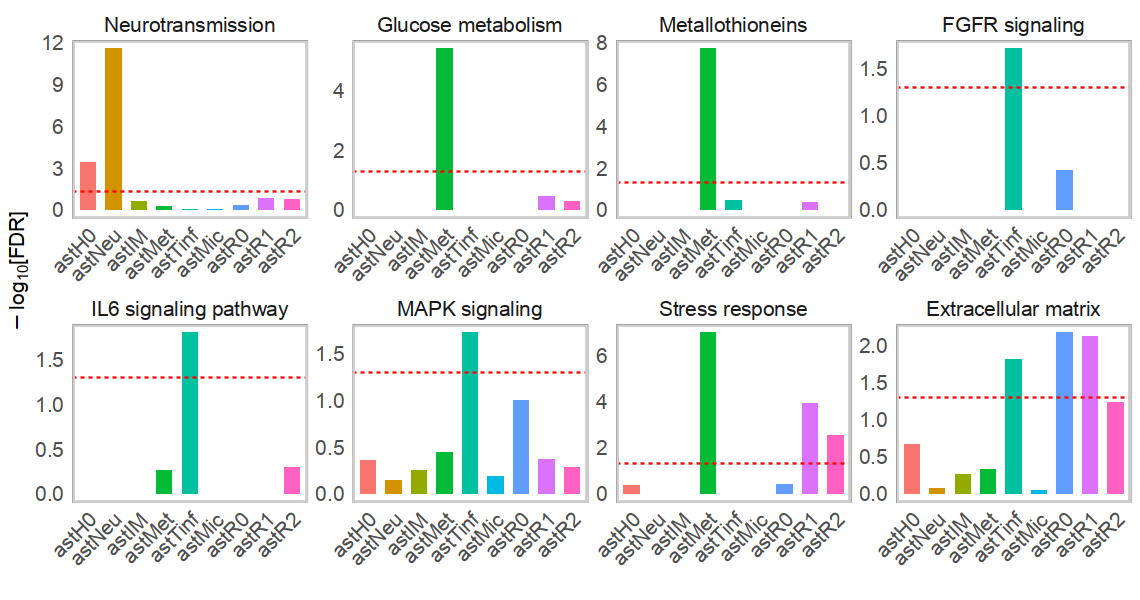

In [50]:
library(scales) 
options(repr.plot.width = 9.5, repr.plot.height = 5)
horizontal_lines <- data.frame(pathway_names = unique(plot_df$pathway_names),
                               y_value = rep(1.3, length(unique(plot_df$pathway_names))))
ggplot(plot_df, aes(x = Sample_Name, y = neglogPadj, fill = Sample_Name)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.6) +    #theme_bw(base_size = 15) +
  facet_wrap(~pathway_names, ncol = 4, scales = "free") + #scales = "free_x"
  #geom_col(position = "fill", width = 0.5) +
  scale_fill_manual(values = hue_pal()(9)) +
  theme_minimal() + my_theme +
  theme(panel.border = element_rect(color = "gray80", fill = NA, size = 1),
        panel.background = element_rect(fill = "white"),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "", y = expression(-log[10]* "[FDR]")) +
  theme(legend.position="none") +
  geom_hline(data = horizontal_lines, aes(yintercept = y_value),  # Add horizontal lines
             color = "red", linetype = "dashed", size = 0.5) 

horizontal -- 

In [114]:
###
plot_df$Sample_Name = factor(plot_df$Sample_Name, levels=rev(cluster_names))

Warning message:
“Removed 23 rows containing missing values (`geom_bar()`).”


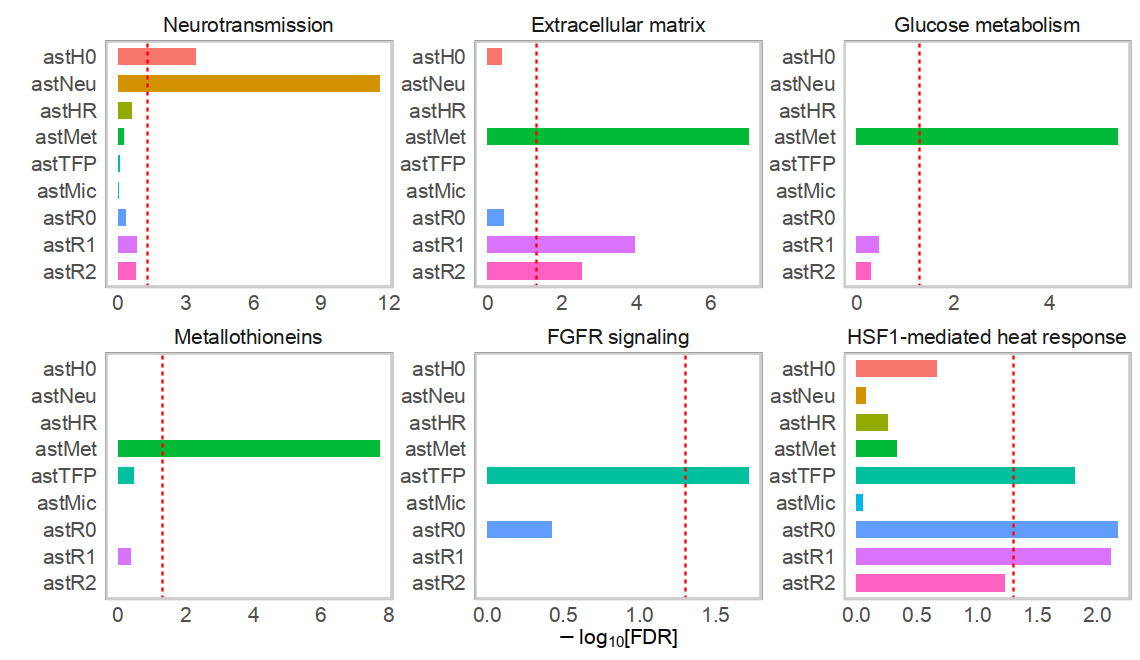

In [115]:
library(ggplot2)
library(scales)

# Create example data for horizontal lines
horizontal_lines <- data.frame(pathway_names = unique(plot_df$pathway_names),
                               x_value = rep(1.3, length(unique(plot_df$pathway_names))))

options(repr.plot.width = 9.5, repr.plot.height = 5.5)
ggplot(plot_df, aes(y = Sample_Name, x = neglogPadj, fill = Sample_Name)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.6) +
  facet_wrap(~pathway_names, ncol = 3, scales = "free") +
  scale_fill_manual(values = rev(hue_pal()(9))) +
  theme_minimal() + my_theme+
  theme(panel.border = element_rect(color = "gray80", fill = NA, size = 1),
        panel.background = element_rect(fill = "white"),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.text.y = element_text(angle = 0, hjust = 1)) +  # Adjust y-axis text angle
  labs(y = "", x = expression(-log[10]* "[FDR]")) +  # Switch x and y labels
  theme(legend.position = "none") +
  geom_vline(data = horizontal_lines, aes(xintercept = x_value),  # Add vertical lines
             color = "red", linetype = "dashed", size = 0.5)